### Распознавание еды

Пытался разобрать пример с kaggle: https://www.kaggle.com/code/farzanansari/finetuning-google-net-food-recognition-2020 <br>


In [1]:
import pandas as pd
import json

# создади датафрейм из json-файла
def create_dataframe(annotations_path):
    # загружаем данные
    with open(annotations_path, 'r') as file:
        data = json.load(file)

    # создаем датафрейм изображений из списка изображений и меняем названия столбцов
    images = pd.DataFrame(data['images']).rename(columns={'id': 'image_id'})[['image_id', 'file_name']]

    # создаем датафрейм категорий
    categories = pd.DataFrame(data['categories'])[['id', 'name']]
    categories.rename(columns={'id': 'category_id'}, inplace=True)

    # объединяем два датафрейма по id
    usecols = ['image_id', 'category_id']
    annotations = pd.DataFrame(data['annotations'])[usecols]

    dataframe = annotations.merge(categories, on='category_id').merge(images, on='image_id')[['file_name', 'name']]
    
    return dataframe

В исследование используется датасет Food Recognition 2022, содержащий почти 40000 фотографий обучающего набора и 1000 - для теста

In [2]:
# сократим обучающую выборку до 10000
train_df = create_dataframe(r'/kaggle/input/food-recognition-2022/raw_data/public_training_set_release_2.0/annotations.json')[:10000]
train_df

,file_name,name
0,131094.jpg,soft-cheese
1,131094.jpg,ham-raw
2,131094.jpg,hard-cheese
3,131094.jpg,bread-wholemeal
4,131094.jpg,cottage-cheese
...,...,...
9995,155171.jpg,chips-french-fries
9996,155171.jpg,ketchup
9997,024157.jpg,chips-french-fries
9998,024509.jpg,chips-french-fries


In [4]:
validation_df = create_dataframe(r'/kaggle/input/food-recognition-2022/raw_data/public_validation_set_2.0/annotations.json')[:1000]
validation_df

,file_name,name
0,149022.jpg,espresso-with-caffeine
1,149022.jpg,dark-chocolate
2,167905.jpg,espresso-with-caffeine
3,121313.jpg,espresso-with-caffeine
4,153429.jpg,espresso-with-caffeine
...,...,...
995,162090.jpg,cappuccino
996,138026.jpg,bread-wholemeal
997,138026.jpg,philadelphia
998,178115.jpg,bread-wholemeal


создаем папки для копий датафрейма

In [3]:
import os

splits = ['train', 'validation']

for split in splits:
    root = f'/kaggle/working/dataset/{split}'

    for index, row in train_df.iterrows():
        directory_name = row['name']
        directory_path = os.path.join(root, directory_name)

        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

In [5]:
import os
import shutil

def copy_images_to_destination(base_dir, dataframe, split):
    images_dir = os.path.join(base_dir, 'images')

    for index, row in dataframe.iterrows():
        file_name = row['file_name']
        file_class = row['name']

        dest_dir = os.path.join('/kaggle/working', 'dataset', split, file_class)
        os.makedirs(dest_dir, exist_ok=True)

        source_path = os.path.join(images_dir, file_name)
        destination_path = os.path.join(dest_dir, file_name)

        shutil.copyfile(source_path, destination_path)

    print("Done copying images.")

In [6]:
# копируем обучающие данные

base_dir = '/kaggle/input/food-recognition-2022/raw_data/public_training_set_release_2.0'
dataframe = train_df
copy_images_to_destination(base_dir, dataframe, 'train')

Done copying images.


In [7]:
# копируем тестовые данные

base_dir = '/kaggle/input/food-recognition-2022/raw_data/public_validation_set_2.0'
dataframe = validation_df
copy_images_to_destination(base_dir, dataframe, 'validation')

Done copying images.


In [8]:
from tensorflow.keras.utils import image_dataset_from_directory as ImageDataset

# создаем датасет для обучения, с категоризацией, размером батча 300, и размером картинок 299х299
train = ImageDataset(
    directory=r'/kaggle/working/dataset/train',
    label_mode='categorical',
    batch_size=300,
    image_size=(299, 299)
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 70397 files belonging to 498 classes.


In [9]:
# создаем датасет для теста
validation = ImageDataset(
    directory=r'/kaggle/working/dataset/validation',
    label_mode='categorical',
    batch_size=100,
    image_size=(299, 299)
)

Found 1799 files belonging to 498 classes.


разделим тестовый датасет на изображение и ответы (метки)

In [10]:
element = validation.as_numpy_iterator().next()

In [11]:
x, y = element
x[0].shape, y[0].shape

((299, 299, 3), (498,))

In [12]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

# создается стратегия для распределения обучения пл разным GPU
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # берем модель InceptionResNetV2
    inception = InceptionResNetV2(include_top=False,
                          weights='imagenet')

    inception.trainable = False

    inputs = keras.Input(shape=(None, None, 3))

    x = preprocess_input(inputs)
    # подготовленные данные прогоняются через модель Inception
    x = inception(x, training=False)
    # полученные данные проходят через сверточный слой
    x = keras.layers.GlobalAveragePooling2D()(x)
    # полносвязанный слой с софтмаксом для классификации
    outputs = keras.layers.Dense(498, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=[tf.keras.metrics.CategoricalAccuracy()])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, None, None, 3)     0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, None, None, 3)     0         
 da)                                                             
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                     

In [13]:
# задаем колбек для избежания переобучения
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

обучаем модель на 20 эпохах

In [16]:
%%time
history = model.fit(train,
                    epochs=20,
                    validation_data=validation,
                    verbose=1,
                    callbacks=[callback]
                   )

Epoch 1/20
235/235 [==============================] - 410s 2s/step - loss: 3.3062 - categorical_accuracy: 0.2884 - val_loss: 3.7319 - val_categorical_accuracy: 0.2607
Epoch 2/20
235/235 [==============================] - 404s 2s/step - loss: 3.2186 - categorical_accuracy: 0.2984 - val_loss: 3.6933 - val_categorical_accuracy: 0.2535
Epoch 3/20
235/235 [==============================] - 410s 2s/step - loss: 3.1476 - categorical_accuracy: 0.3055 - val_loss: 3.6872 - val_categorical_accuracy: 0.2579
Epoch 4/20
235/235 [==============================] - 419s 2s/step - loss: 3.0845 - categorical_accuracy: 0.3143 - val_loss: 3.6958 - val_categorical_accuracy: 0.2618
Epoch 5/20
235/235 [==============================] - 411s 2s/step - loss: 3.0285 - categorical_accuracy: 0.3210 - val_loss: 3.6879 - val_categorical_accuracy: 0.2646
Epoch 6/20
235/235 [==============================] - 406s 2s/step - loss: 2.9819 - categorical_accuracy: 0.3264 - val_loss: 3.6997 - val_categorical_accuracy: 0.262

обучение было остановлено на 15 эпохе. Точность небольшая, около 27%

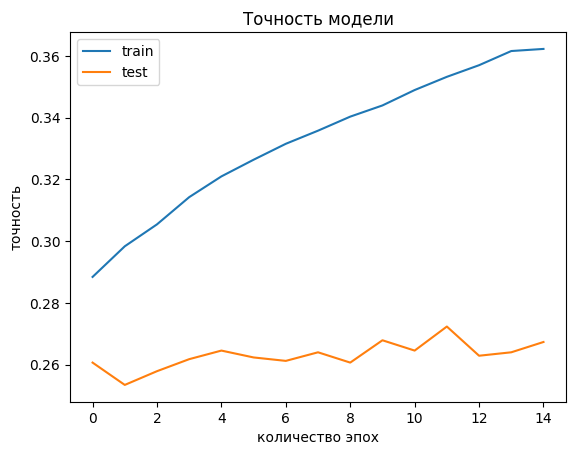

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Вывод: Пытался попробовать воспользоваться готовым кодом на kaggle, чтобы посмотреть возможности применения нейросетей в своей отрасли (например, чтобы распознать ингредиенты в блюде). В ходе исследования несколько раз запускал модель с исходными параметрами (batch_size=32) и разным количеством эпох (от 1 до 10). Модель очень долго обучалась и не показывала достаточно высокий результат (максимум было 23% точности). С увеличением размера батча точность и скорость немного повысилась, но недостаточно, чтобы применить модель на реальных примерах. Все-таки для обучения таких моделей необходимо большие ресурсы, чем у меня в наличии.